Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
# import pathlib
# import tensorflow as tf
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import os
# import PIL
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.models import Sequential
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [3]:
train_path = "gdrive/My Drive/Train/"
test_path = "gdrive/My Drive/Test/"


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
##train_ds = ##todo
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_ds = image_dataset_from_directory(data_dir_train, 
                                        seed = 123, 
                                        image_size=(img_height, img_width), 
                                        validation_split=0.2, 
                                        subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

##val_ds = ##todo
val_ds = image_dataset_from_directory(data_dir_train, 
                                      seed = 123, 
                                      image_size=(img_height, img_width), 
                                      validation_split=0.2, 
                                      subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

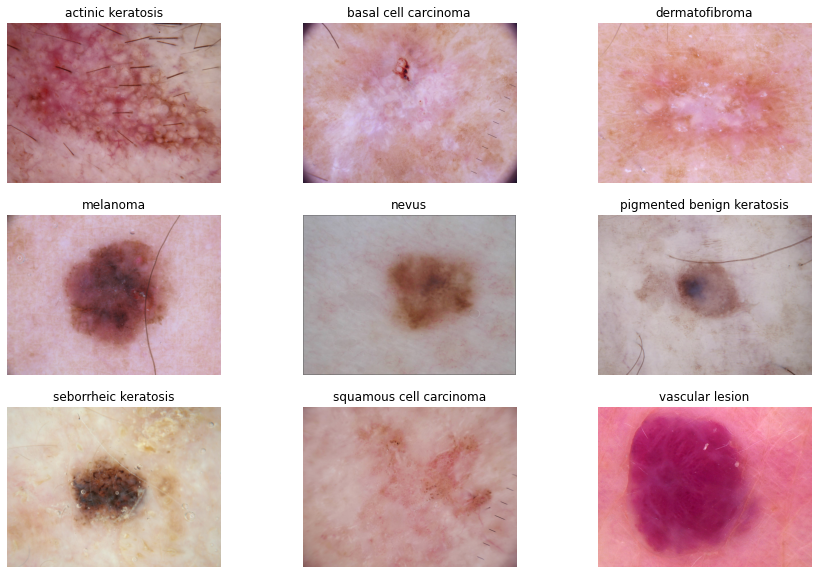

In [ ]:
import matplotlib.pyplot as plt
### Visualizing the training data

plt.figure(figsize=(15, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)
    data_path = os.path.join(str(data_dir_train), class_)
    file_path = glob.glob(os.path.join(data_path,'*.jpg'))[0]
    img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")
plt.show()


In [ ]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [ ]:
# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(ex)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

Compile the model

Choose an appropirate optimiser and loss function for model training

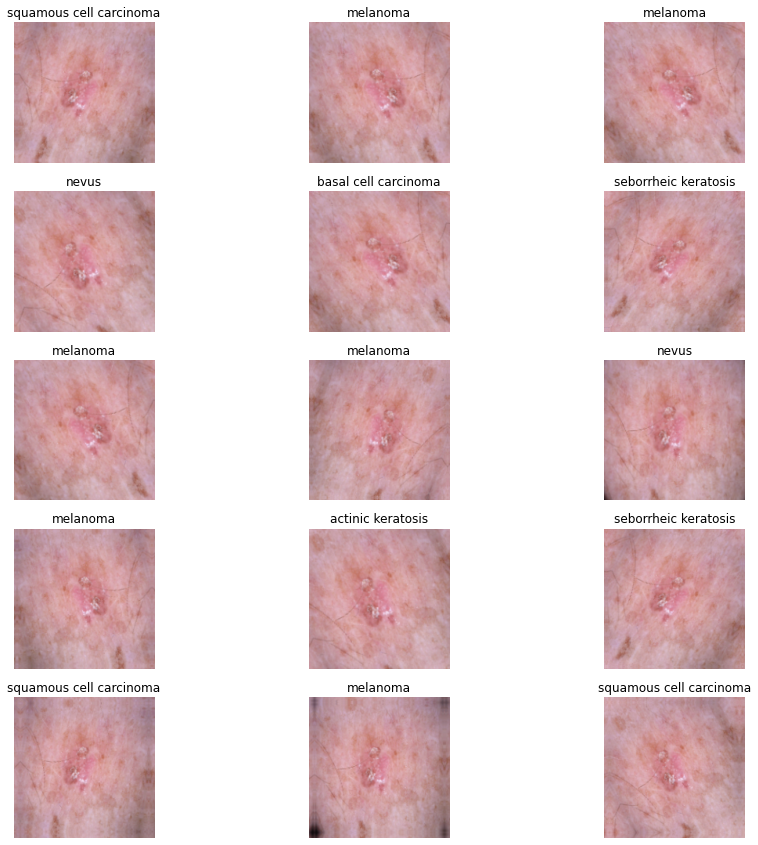

In [ ]:
plt.figure(figsize=(15, 15))
for images, label in train_ds.take(1):
    for i in range(15):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

In [ ]:
num_classes = 9

# Building model with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model = data_augmentation
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

In [ ]:
### Your code goes here


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Todo, choose an appropirate optimiser and loss function
# model.compile(optimizer='your_optimser',
#               loss=your_loss_function_goes_here,
#               metrics=['accuracy'])
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 activation (Activation)     (None, 180, 180, 16)      0         
                                                        

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 142s 2s/step - loss: 2.1160 - accuracy: 0.2227 - val_loss: 1.9059 - val_accuracy: 0.2975
Epoch 2/20
56/56 [==============================] - 1s 26ms/step - loss: 1.8692 - accuracy: 0.3108 - val_loss: 1.7702 - val_accuracy: 0.4027
Epoch 3/20
56/56 [==============================] - 1s 26ms/step - loss: 1.7272 - accuracy: 0.3666 - val_loss: 1.6301 - val_accuracy: 0.4385
Epoch 4/20
56/56 [==============================] - 1s 26ms/step - loss: 1.6493 - accuracy: 0.4163 - val_loss: 1.5067 - val_accuracy: 0.5101
Epoch 5/20
56/56 [==============================] - 1s 26ms/step - loss: 1.4968 - accuracy: 0.4721 - val_loss: 1.6576 - val_accuracy: 0.4362
Epoch 6/20
56/56 [==============================] - 1s 26ms/step - loss: 1.4545 - accuracy: 0.4860 - val_loss: 1.4399 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 1s 26ms/step - loss: 1.3858 - accuracy: 0.5156 - val_loss: 1.4505 - val_accuracy: 0.5168
Epoch 8/20
56

### Visualizing training results

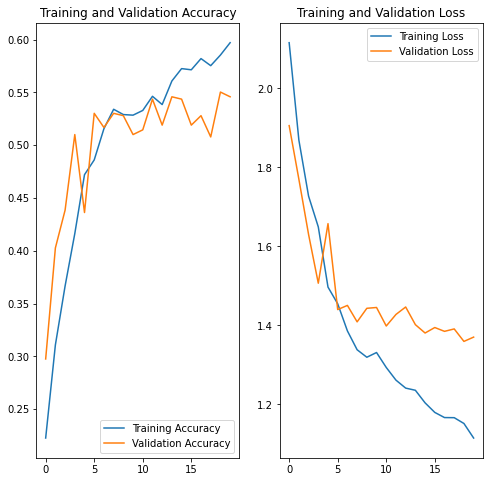

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
Model is underfit where accuracy is around 54 percent on both training and validation.

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

**Distribution of classes in the training dataset.**

Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
class_size = {}

for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.jpg')))

class_size

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

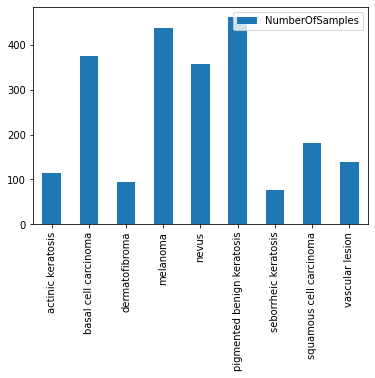

In [ ]:
class_df = pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'NumberOfSamples'])
class_df.drop(['ClassName'], axis = 1, inplace=True)
class_df
class_df.plot.bar()
plt.show()

### Rectify the class imbalance

In [ ]:
!pip install Augmentor
import Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
for i in class_names:
    p = Augmentor.Pipeline(train_path + i, output_directory='gdrive/My Drive/train_augment/'+i+'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000)

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/Train/actinic keratosis/gdrive/My Drive/train_augment/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBFD1C3A850>: 100%|██████████| 1000/1000 [00:35<00:00, 28.13 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/Train/basal cell carcinoma/gdrive/My Drive/train_augment/basal cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBFD21466D0>: 100%|██████████| 1000/1000 [00:35<00:00, 28.56 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/Train/dermatofibroma/gdrive/My Drive/train_augment/dermatofibroma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBFD07C7710>: 100%|██████████| 1000/1000 [00:35<00:00, 27.91 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/Train/melanoma/gdrive/My Drive/train_augment/melanoma/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBFD06E1190>: 100%|██████████| 1000/1000 [02:59<00:00,  5.58 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/Train/nevus/gdrive/My Drive/train_augment/nevus/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x719 at 0x7FBFD1CAAB90>: 100%|██████████| 1000/1000 [02:36<00:00,  6.37 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/Train/pigmented benign keratosis/gdrive/My Drive/train_augment/pigmented benign keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC0DBF4D690>: 100%|██████████| 1000/1000 [00:35<00:00, 28.27 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/Train/seborrheic keratosis/gdrive/My Drive/train_augment/seborrheic keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FBFCFA1BC50>: 100%|██████████| 1000/1000 [01:21<00:00, 12.30 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/Train/squamous cell carcinoma/gdrive/My Drive/train_augment/squamous cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBFCFA55710>: 100%|██████████| 1000/1000 [00:34<00:00, 29.16 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/Train/vascular lesion/gdrive/My Drive/train_augment/vascular lesion/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC064062E90>: 100%|██████████| 1000/1000 [00:35<00:00, 28.26 Samples/s]


In [ ]:
output_dir = pathlib.Path('gdrive/My Drive/train_augment/')

In [ ]:
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
image_count_train

9000

## Train the model on the data created using Augmentor

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 7200 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Todo:
### Create the model, compile and train the model

In [ ]:
# Model - Rescaling -> Conv2D -> MaxPooling2D -> Dropout -> Conv2D -> MaxPooling2D -> Dropout -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

### Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 activation_4 (Activation)   (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

### Training the model

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
225/225 [==============================] - 33s 50ms/step - loss: 2.2880 - accuracy: 0.1158 - val_loss: 2.1966 - val_accuracy: 0.1072
Epoch 2/30
225/225 [==============================] - 6s 28ms/step - loss: 1.7983 - accuracy: 0.2982 - val_loss: 1.6147 - val_accuracy: 0.3839
Epoch 3/30
225/225 [==============================] - 6s 26ms/step - loss: 1.4491 - accuracy: 0.4432 - val_loss: 1.3954 - val_accuracy: 0.5022
Epoch 4/30
225/225 [==============================] - 6s 25ms/step - loss: 1.2798 - accuracy: 0.5203 - val_loss: 1.2277 - val_accuracy: 0.5639
Epoch 5/30
225/225 [==============================] - 6s 25ms/step - loss: 1.1595 - accuracy: 0.5714 - val_loss: 1.2235 - val_accuracy: 0.5644
Epoch 6/30
225/225 [==============================] - 6s 25ms/step - loss: 1.0138 - accuracy: 0.6335 - val_loss: 0.9988 - val_accuracy: 0.6550
Epoch 7/30
225/225 [==============================] - 6s 25ms/step - loss: 0.8703 - accuracy: 0.6915 - val_loss: 0.9232 - val_accuracy: 0.696

### Visualizing the results

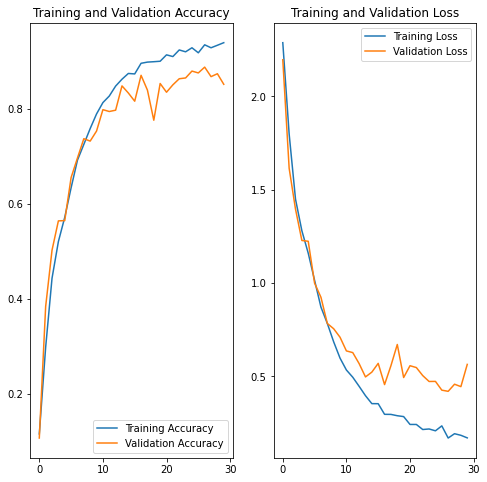

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Ans : As you can see accuracy on both training and and validation got improved quite significantly from 54 percent to 91 percent and almost similar on both so it is a good fit

### Lets see the distribution of augmented data after adding new images to the original training data.

In [17]:
data_dir_train_new='gdrive/My Drive/train_augment/'
data_dir_train_new = pathlib.Path(data_dir_train_new)
class_size={}
for name in class_names:
    class_size[name] = len(list(data_dir_train_new.glob(name+'/output/*.jpg')))

class_size

{'actinic keratosis': 1000,
 'basal cell carcinoma': 1000,
 'dermatofibroma': 1000,
 'melanoma': 1000,
 'nevus': 1000,
 'pigmented benign keratosis': 1000,
 'seborrheic keratosis': 1000,
 'squamous cell carcinoma': 1000,
 'vascular lesion': 1000}

So, now we have added 1000 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [ ]:
## your code goes here

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Yes it improved accuracy as well as helped us to get rid of underfitting

